In [1]:
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
import sklearn

print("scikit-learn version:", sklearn.__version__)

scikit-learn version: 1.3.0


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d msambare/fer2013

 75% 45.0M/60.3M [00:00<00:00, 112MB/s]
100% 60.3M/60.3M [00:00<00:00, 122MB/s]


In [9]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fer2013.zip', 'r')
zip_ref.extractall('/content/folder')
zip_ref.close()

In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
from tensorflow.keras.utils import load_img , img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense , Input , Dropout , MaxPooling2D , GlobalAveragePooling2D , BatchNormalization ,Flatten , Conv2D , Activation
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD

In [8]:
train_path = '/content/train'
val_path = '/content/test'

In [10]:
folder_path = "/content/folder"
picture_size = 48

In [11]:
def plot_images(image_dir):
    plt.figure(figsize=(12,12))
    for i in range(1, 10, 1):
        plt.subplot(3,3,i)
        img = load_img(image_dir+"/"+
                  os.listdir(image_dir)[i], target_size=(picture_size, picture_size))
        plt.imshow(img)
    plt.show()

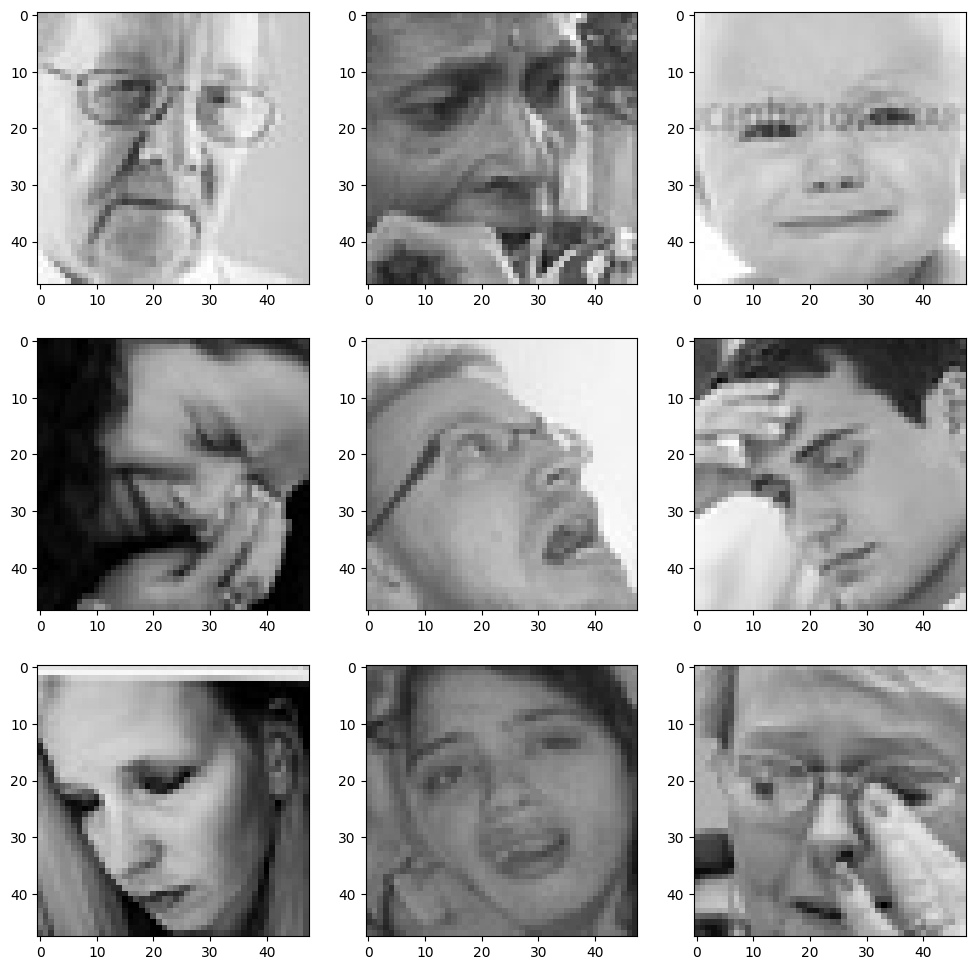

In [12]:
Expression = "sad"
plot_images(train_path+"/"+Expression)

In [13]:
datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

In [14]:
train_set = datagen_train.flow_from_directory(train_path, target_size=(picture_size,picture_size),
                                             color_mode = "grayscale",
                                             batch_size = 128,
                                             class_mode = "categorical",
                                             shuffle = True)

Found 28709 images belonging to 7 classes.


In [15]:
test_set = datagen_val.flow_from_directory(val_path, target_size=(picture_size,picture_size),
                                             color_mode = "grayscale",
                                             batch_size = 128,
                                             class_mode = "categorical",
                                             shuffle = False)

Found 7178 images belonging to 7 classes.


In [16]:
model = Sequential()
#1st CNN layer
model.add(Conv2D(64,(3,3),padding = "same", input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

In [17]:
#2nd CNN layer
model.add(Conv2D(128,(3,3),padding = "same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

In [18]:
#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = "same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

In [19]:
#flattening operation
model.add(Flatten())

In [20]:
#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

In [21]:
#Fully connected 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

In [22]:
model.add(Dense(7, activation='softmax'))

In [23]:
LOSS_FUNCTION = "categorical_crossentropy"
OPTIMIZER = "SGD"
METRICS = ['accuracy']
model.compile(optimizer=OPTIMIZER,loss=LOSS_FUNCTION, metrics=METRICS)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       7

In [24]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [25]:
CKPT_PATH = "model_ckpt.h5"
checkpointing_cb = ModelCheckpoint(CKPT_PATH, monitor='val_acc', verbose=1,save_best_only = True, mode='max')

In [26]:
early_stopping = EarlyStopping(patience=3,monitor='val_loss',verbose=1,min_delta=0,restore_best_weights=True)

In [27]:
reduce_learningrate = ReduceLROnPlateau(patience=3,monitor='val_loss',verbose=1,factor=0.2,min_delta=0.0001)
callbacks_list = [checkpointing_cb,early_stopping,reduce_learningrate]
model.compile(loss= LOSS_FUNCTION,optimizer = OPTIMIZER,metrics=METRICS)

In [28]:
EPOCHS = 20
batch_size = 128

In [29]:
history = model.fit_generator(generator=train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=EPOCHS,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

<ipython-input-29-28a96e7eb2be>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/20
223/224 [============================>.] - ETA: 0s - loss: 1.9532 - accuracy: 0.2525

224/224 [==============================] - 31s 66ms/step - loss: 1.9521 - accuracy: 0.2529 - val_loss: 1.6909 - val_accuracy: 0.3199 - lr: 0.0100
Epoch 2/20
223/224 [============================>.] - ETA: 0s - loss: 1.7611 - accuracy: 0.3199

224/224 [==============================] - 16s 72ms/step - loss: 1.7612 - accuracy: 0.3200 - val_loss: 1.6350 - val_accuracy: 0.3504 - lr: 0.0100
Epoch 3/20
224/224 [==============================] - ETA: 0s - loss: 1.6729 - accuracy: 0.3542

224/224 [==============================] - 17s 76ms/step - loss: 1.6729 - accuracy: 0.3542 - val_loss: 1.5731 - val_accuracy: 0.3922 - lr: 0.0100
Epoch 4/20
224/224 [==============================] - ETA: 0s - loss: 1.6052 - accuracy: 0.3804

224/224 [==============================] - 17s 76ms/step - loss: 1.6052 - accuracy: 0.3804 - val_loss: 1.5159 - val_accuracy: 0.4136 - lr: 0.0100
Epoch 5/20
223/224 [============================>.] - ETA: 0s - loss: 1.5525 - accuracy: 0.4003

224/224 [==============================] - 17s 74ms/step - loss: 1.5519 - accuracy: 0.4004 - val_loss: 1.4870 - val_accuracy: 0.4210 - lr: 0.0100
Epoch 6/20
223/224 [============================>.] - ETA: 0s - loss: 1.5174 - accuracy: 0.4120

224/224 [==============================] - 20s 87ms/step - loss: 1.5169 - accuracy: 0.4124 - val_loss: 1.4694 - val_accuracy: 0.4330 - lr: 0.0100
Epoch 7/20
224/224 [==============================] - ETA: 0s - loss: 1.4812 - accuracy: 0.4290

224/224 [==============================] - 18s 82ms/step - loss: 1.4812 - accuracy: 0.4290 - val_loss: 1.6652 - val_accuracy: 0.3961 - lr: 0.0100
Epoch 8/20
224/224 [==============================] - ETA: 0s - loss: 1.4515 - accuracy: 0.4400

224/224 [==============================] - 15s 68ms/step - loss: 1.4515 - accuracy: 0.4400 - val_loss: 1.4042 - val_accuracy: 0.4573 - lr: 0.0100
Epoch 9/20
224/224 [==============================] - ETA: 0s - loss: 1.4244 - accuracy: 0.4501

224/224 [==============================] - 23s 103ms/step - loss: 1.4244 - accuracy: 0.4501 - val_loss: 1.4513 - val_accuracy: 0.4422 - lr: 0.0100
Epoch 10/20
223/224 [============================>.] - ETA: 0s - loss: 1.3994 - accuracy: 0.4599

224/224 [==============================] - 17s 74ms/step - loss: 1.3999 - accuracy: 0.4596 - val_loss: 1.4040 - val_accuracy: 0.4644 - lr: 0.0100
Epoch 11/20
224/224 [==============================] - ETA: 0s - loss: 1.3830 - accuracy: 0.4665

224/224 [==============================] - 16s 73ms/step - loss: 1.3830 - accuracy: 0.4665 - val_loss: 1.3791 - val_accuracy: 0.4724 - lr: 0.0100
Epoch 12/20
224/224 [==============================] - ETA: 0s - loss: 1.3637 - accuracy: 0.4743

224/224 [==============================] - 23s 102ms/step - loss: 1.3637 - accuracy: 0.4743 - val_loss: 1.3246 - val_accuracy: 0.4894 - lr: 0.0100
Epoch 13/20
224/224 [==============================] - ETA: 0s - loss: 1.3460 - accuracy: 0.4836

224/224 [==============================] - 16s 72ms/step - loss: 1.3460 - accuracy: 0.4836 - val_loss: 1.4190 - val_accuracy: 0.4630 - lr: 0.0100
Epoch 14/20
224/224 [==============================] - ETA: 0s - loss: 1.3281 - accuracy: 0.4934

224/224 [==============================] - 15s 65ms/step - loss: 1.3281 - accuracy: 0.4934 - val_loss: 1.2906 - val_accuracy: 0.5008 - lr: 0.0100
Epoch 15/20
224/224 [==============================] - ETA: 0s - loss: 1.3217 - accuracy: 0.4947

224/224 [==============================] - 14s 63ms/step - loss: 1.3217 - accuracy: 0.4947 - val_loss: 1.2967 - val_accuracy: 0.4986 - lr: 0.0100
Epoch 16/20
223/224 [============================>.] - ETA: 0s - loss: 1.3016 - accuracy: 0.5018

224/224 [==============================] - 16s 74ms/step - loss: 1.3019 - accuracy: 0.5017 - val_loss: 1.3585 - val_accuracy: 0.4834 - lr: 0.0100
Epoch 17/20
224/224 [==============================] - ETA: 0s - loss: 1.2888 - accuracy: 0.5066

224/224 [==============================] - 14s 64ms/step - loss: 1.2888 - accuracy: 0.5066 - val_loss: 1.2877 - val_accuracy: 0.5045 - lr: 0.0100
Epoch 18/20
224/224 [==============================] - ETA: 0s - loss: 1.2750 - accuracy: 0.5122

224/224 [==============================] - 14s 63ms/step - loss: 1.2750 - accuracy: 0.5122 - val_loss: 1.2949 - val_accuracy: 0.5018 - lr: 0.0100
Epoch 19/20
224/224 [==============================] - ETA: 0s - loss: 1.2605 - accuracy: 0.5174

224/224 [==============================] - 15s 67ms/step - loss: 1.2605 - accuracy: 0.5174 - val_loss: 1.2625 - val_accuracy: 0.5113 - lr: 0.0100
Epoch 20/20
223/224 [============================>.] - ETA: 0s - loss: 1.2533 - accuracy: 0.5202

224/224 [==============================] - 15s 68ms/step - loss: 1.2533 - accuracy: 0.5201 - val_loss: 1.2210 - val_accuracy: 0.5248 - lr: 0.0100


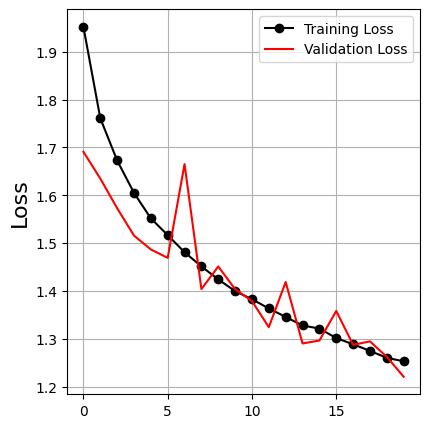

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss', color='black',marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss',color = 'red')
plt.legend(loc=0)
plt.grid('True')

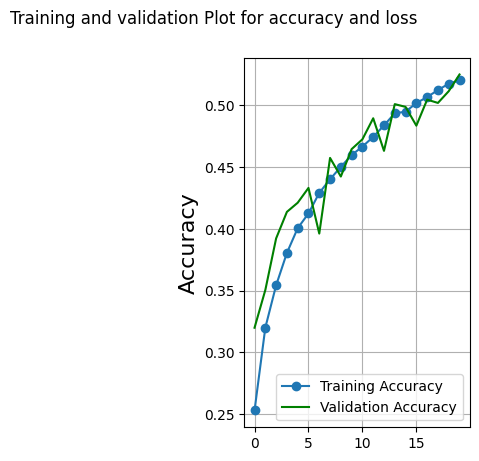

In [31]:
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy',marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color = 'green')
plt.legend(loc=0)
plt.suptitle('Training and validation Plot for accuracy and loss')
plt.grid('True')
plt.show()

In [32]:
train_loss , train_acc  =model.evaluate(train_set)
test_loss , test_acc = model.evaluate(test_set)

57/57 [==============================] - 2s 39ms/step - loss: 1.2199 - accuracy: 0.5254


In [33]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_set), axis=-1)
print(classification_report(test_set.classes, y_pred, target_names=test_set.class_indices.keys()), end='\n\n\n')

57/57 [==============================] - 2s 34ms/step
              precision    recall  f1-score   support

       angry       0.43      0.40      0.41       958
     disgust       0.61      0.25      0.36       111
        fear       0.40      0.20      0.27      1024
       happy       0.67      0.81      0.73      1774
     neutral       0.45      0.55      0.49      1233
         sad       0.39      0.37      0.38      1247
    surprise       0.67      0.69      0.68       831

    accuracy                           0.53      7178
   macro avg       0.52      0.47      0.47      7178
weighted avg       0.51      0.53      0.51      7178





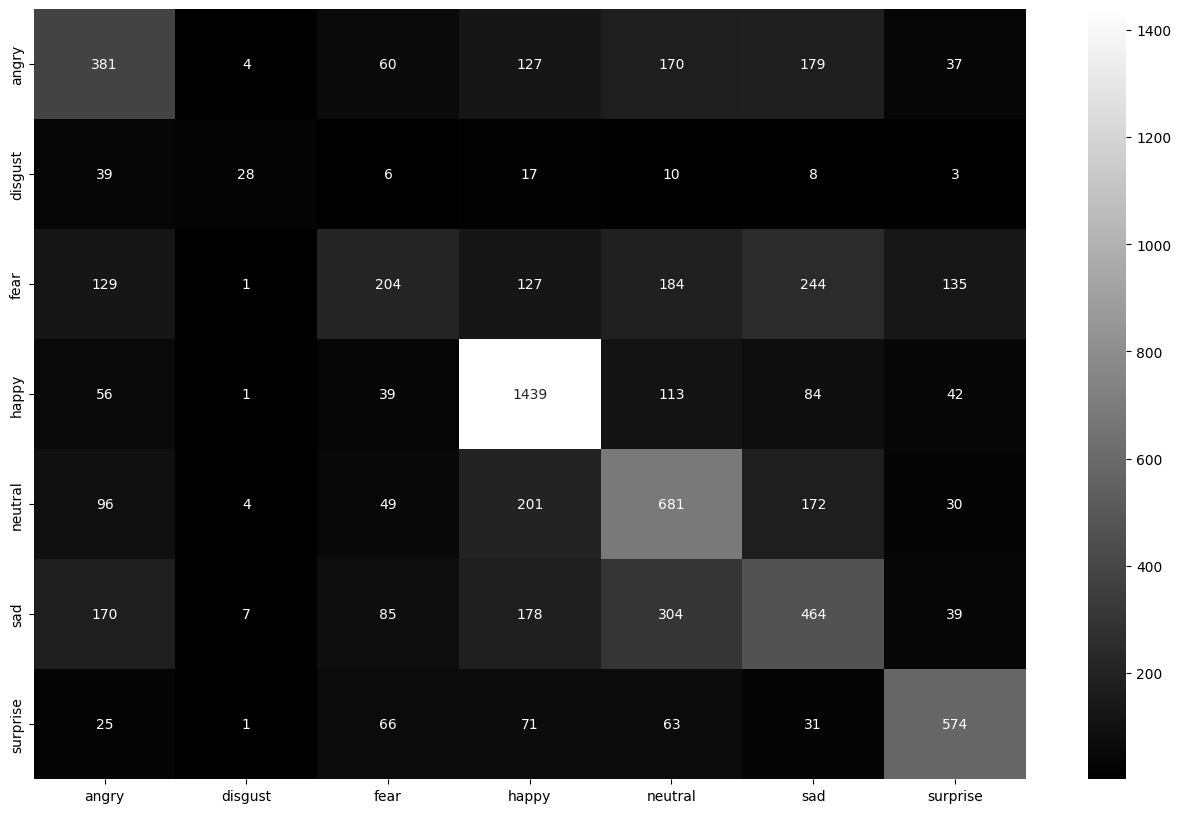

In [34]:
cm = confusion_matrix(test_set.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm, cmap=plt.cm.gray, annot=True, fmt='.0f', xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())
plt.show()

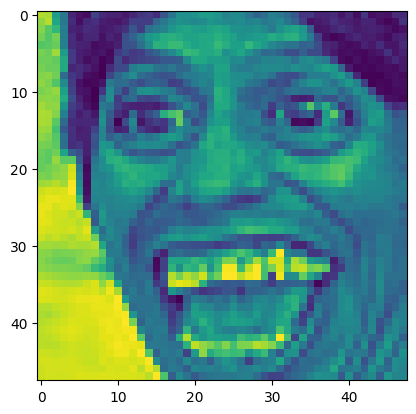

In [35]:
test_img = load_img('/content/folder/test/happy/PrivateTest_10513598.jpg',target_size=(48,48),color_mode = "grayscale")
plt.imshow(test_img)

In [36]:
emotions_dict = {0 : 'Angry', 1 :'Disgusted',2 :'Fear',3:'Happy',4 :'Neutral',5:'Sad',6:'Suprised'}

In [37]:
test_img = np.expand_dims(test_img,axis=0)
test_img = test_img.reshape(1,48,48,1)
final_result = model.predict(test_img)
final_result = list(final_result[0])
image_index = final_result.index(max(final_result))
print(emotions_dict[image_index])

1/1 [==============================] - 0s 262ms/step
Happy


In [38]:
emotions = emotions_dict[image_index]
import random
n = random.randint(0,2167)
from IPython.display import Audio